In [1]:
# Core libraries
import numpy as np
import pandas as pd
import calendar
import os
import sys
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
# import altair_ally as aly

# Time series analysis
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, seasonal_decompose, SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Forecasting models
# from pmdarima import auto_arima

# ML models
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Preprocessing and pipelines
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

# Model evaluation and cross-validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import (
    train_test_split, TimeSeriesSplit, cross_validate, GridSearchCV
)
import shap 

# Optimization
from scipy.optimize import minimize

# sktime
from sktime.forecasting.model_selection import ForecastingGridSearchCV, ExpandingWindowSplitter
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon

%matplotlib inline

/Users/alexwong/miniforge3/envs/sweet_pulse/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Random forest regressor

In [2]:
train_df = pd.read_csv('../data/modelling/train.csv', index_col=0, parse_dates=True)
test_df = pd.read_csv('../data/modelling/test.csv', index_col=0, parse_dates=True)

In [3]:
X_train = train_df.drop(columns=['total_sales_normalized'])
y_train = train_df['total_sales_normalized']

X_test = test_df.drop(columns=['total_sales_normalized'])
y_test = test_df['total_sales_normalized']

In [4]:
numerical_features = ['hours_opened', 'avg_temperature', 'rain', 'snow']
categorical_features = ['is_long_weekend', 'is_HCF', 'season', 'day_of_week', 'is_holiday']
category_orders = [
    [False, True],  # is_long_weekend
    [False, True],  # is_HCF
    ['Winter', 'Spring', 'Summer', 'Fall'],  # season
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],  # day_of_week
    [False, True]  # is_holiday
]
drop_features = ['total_sales_normalized', 'item_B_sales', 'item_C_sales']

preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', categories=category_orders), categorical_features),
    (StandardScaler(), numerical_features),
    ("drop", drop_features)
)


rf = RandomForestRegressor(random_state=123)
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', categories=category_orders), categorical_features),
    (StandardScaler(), numerical_features)
)

rf_pipe = make_pipeline(preprocessor, rf)

In [5]:
rf_pipe.fit(X_train, y_train)
y_pred = rf_pipe.predict(X_test)
y_train_pred = rf_pipe.predict(X_train)

In [6]:
mean_absolute_error(y_test, y_pred)

332.1482333333321

In [7]:
y_train_for_plot = pd.DataFrame(y_train).assign(label='train')
y_test_for_plot = pd.DataFrame(y_test).assign(label='test')
lr_pred_for_plot = pd.DataFrame(y_pred, columns=['total_sales_normalized'], index=y_test.index).assign(label='test_prediction')
y_train_pred_for_plot = pd.DataFrame(y_train_pred, columns=['total_sales_normalized'], index=y_train.index).assign(label='train_prediction')

custom_colors = {
    'train': '#1f77b4',
    'test': '#d62728',
    'test_prediction': '#8bc34a',
    'train_prediction': '#8bc34a'
}

rf_plot_fig = px.line(pd.concat((y_train_for_plot, y_test_for_plot, lr_pred_for_plot, y_train_pred_for_plot)), 
        y="total_sales_normalized",
        color='label', 
        title='Prediction results - random forest',
        color_discrete_map=custom_colors
        )

rf_plot_fig.show()

In [8]:
trained_rf = rf_pipe.named_steps['randomforestregressor']
trained_preprocessor = rf_pipe.named_steps['columntransformer']

columns = (rf_pipe.named_steps['columntransformer'].named_transformers_['onehotencoder'].get_feature_names_out().tolist() + 
           rf_pipe.named_steps['columntransformer'].named_transformers_['standardscaler'].get_feature_names_out().tolist()) 

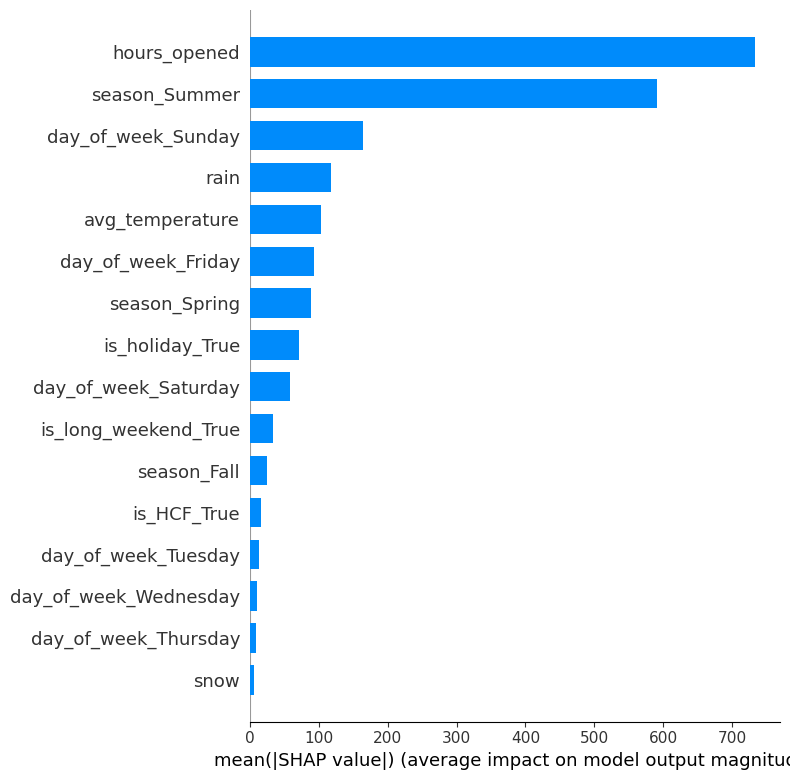

In [9]:
explainer = shap.TreeExplainer(trained_rf)
observations = pd.DataFrame(trained_preprocessor.transform(X_train), columns=columns)
shap_values = explainer.shap_values(observations)
shap.summary_plot(shap_values, observations, plot_type='bar')

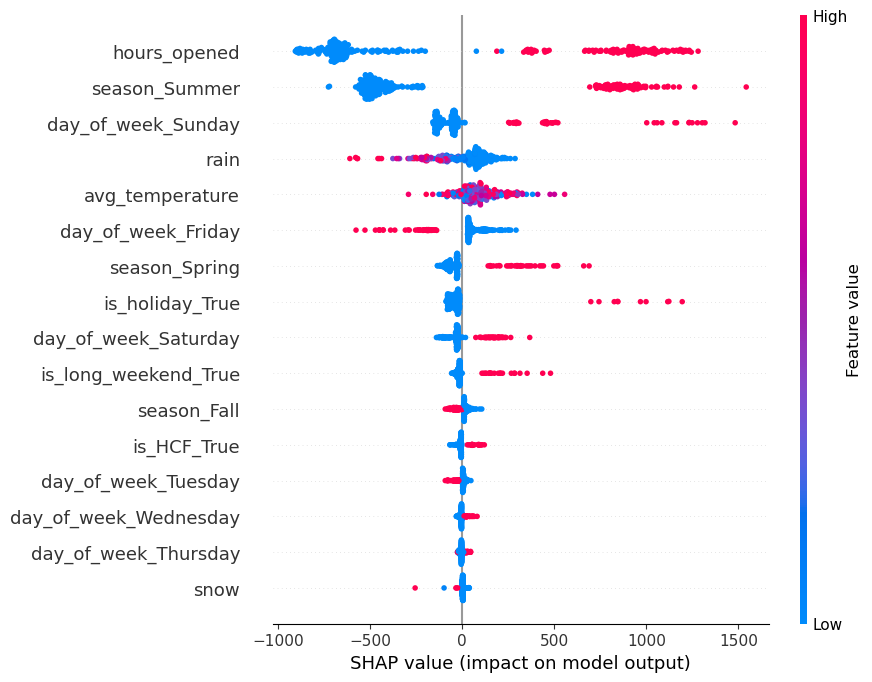

In [10]:
explanation = explainer(observations)
shap.plots.beeswarm(explanation, max_display=50)

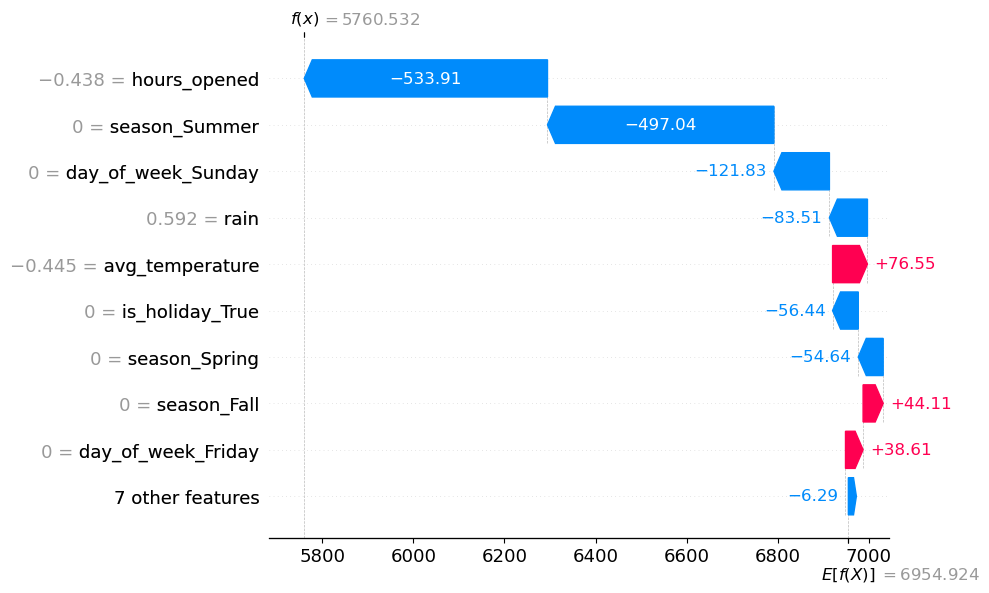

In [11]:
shap.plots.waterfall(explanation[200, :])

### Hyperparameter tuning

In [12]:
param_grid = {
    'randomforestregressor__n_estimators': [10, 50, 100],
    'randomforestregressor__max_features': ['sqrt', 'log2'],
    'randomforestregressor__max_depth': [None, 5, 10, 20],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4],
}

rf = RandomForestRegressor(criterion='absolute_error',random_state=123)
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', categories=category_orders), categorical_features),
    (StandardScaler(), numerical_features)
)
rf_pipe = make_pipeline(preprocessor, rf)

grid_search = GridSearchCV(rf_pipe, param_grid, n_jobs=-1, cv=5, return_train_score = True, scoring = 'neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(categories=[[False,
                                                                                                    True],
                                                                                                   [False,
                                                                                                    True],
                                                                                                   ['Winter',
                                                                                                    'Spring',
                                                                                                    'Summer',
                                                                                                    'Fall'],
                                                                                                   ['Monday',
                                                                                                    'Tuesday',
                                                                                                    'Wednesday',
                                                                                                    'Thursday',
                                                                                                    'Friday',
                                                                                                    'Saturday',
                                                                                                    'Sunday'],
                                                                                                   [False,
                                                                                                    True]],
                                                                                       drop='first'),
                                                                         ['is_long_weekend',
                                                                          'is_HCF',
                                                                          'season',
                                                                          'day_of_we...
                                                              random_state=123))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [None, 5, 10, 20],
                         'randomforestregressor__max_features': ['sqrt',
                                                                 'log2'],
                         'randomforestregressor__min_samples_leaf': [1, 2, 4],
                         'randomforestregressor__min_samples_split': [2, 5, 10],
                         'randomforestregressor__n_estimators': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [13]:
pd.DataFrame(grid_search.cv_results_)[

    ['rank_test_score',
     'mean_test_score',
     'mean_train_score',
     'mean_fit_time',
     'mean_score_time',
     'param_randomforestregressor__max_depth', 
     'param_randomforestregressor__max_features', 
     'param_randomforestregressor__min_samples_leaf', 
     'param_randomforestregressor__min_samples_split', 
     'param_randomforestregressor__n_estimators',
    ]
].set_index('rank_test_score').sort_index()

,mean_test_score,mean_train_score,mean_fit_time,mean_score_time,param_randomforestregressor__max_depth,param_randomforestregressor__max_features,param_randomforestregressor__min_samples_leaf,param_randomforestregressor__min_samples_split,param_randomforestregressor__n_estimators
rank_test_score,,,,,,,,,
1,-532.725413,-251.268660,0.077702,0.007217,20,log2,1,5,50
1,-532.725413,-251.268660,0.075962,0.007737,20,sqrt,1,5,50
3,-532.764806,-251.334406,0.137882,0.007583,None,sqrt,1,5,50
3,-532.764806,-251.334406,0.087690,0.008874,None,log2,1,5,50
5,-533.510144,-210.073821,0.173405,0.008991,10,log2,1,2,100
...,...,...,...,...,...,...,...,...,...
211,-675.337636,-444.443055,0.013372,0.004409,5,sqrt,4,5,10
211,-675.337636,-444.443055,0.016325,0.002874,5,log2,4,2,10
211,-675.337636,-444.443055,0.016485,0.004401,5,sqrt,4,2,10
